In [1]:
#### Modulos
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
import os
import numpy as np
import rpy2.robjects as robjects
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt; plt.rcdefaults()
from networkx.algorithms.community.centrality import girvan_newman
from operator import itemgetter
#################

In [2]:
G = nx.read_gml("dolphins.gml")

a) Comunidades

In [3]:
#### Este es el algoritmo que utiliza packetes de redes en R para defirnir comunidades
def community(nxG, algorithm, fig_name = "G"):
    """
    In:
        nxG: grafo de networkx.
        algorithm: string, entre las siguientes opciones: 
            fast_greedy
            edge_betweenness
            louvain
            infomap
        fig_name: nombre de la figura que se genera al clsuterizar. Le agrega automaticamente el nombre del algoritmo usado y el nombre del grafo si lo tuviere
    Out:
        labels: numpy array con la pertenencia de cada nodo al cluster.
    
    """
    gml_file_name = "G.gml"
    fig_name += "_"+nxG.name+"_"+algorithm+".svg"
    nx.write_gml(nxG, gml_file_name)
    
    igG = robjects.r('''
        f <- function(file, algorithm, fig_name, v_names){
            require("igraph")     
            
            G <- read.graph(file, "gml")
            V(G)$name <- as.character(unlist(v_names))
            #format = c("edgelist", "pajek", "ncol", "lgl", "graphml","dimacs", "graphdb", "gml", "dl"), ...)
            
            if(algorithm == "fast_greedy"){
                c <- fastgreedy.community(G)
                #c <- cluster_fast_greedy(G, merges = TRUE, modularity = TRUE, membership = TRUE)
            }
            
            if(algorithm == "edge_betweenness"){
                c <- edge.betweenness.community(G)
                #c <- cluster_edge_betweenness(G,directed = FALSE,edge.betweenness = TRUE)
            }
            
            if(algorithm == "louvain"){
                c <- multilevel.community(G)
                #c <- cluster_louvain(G)
            }
            
            if(algorithm == "infomap"){
                #c <- cluster_infomap(G)
                c <- infomap.community(G)
            }
            
            svg(fig_name)
            plot(c, G)
            dev.off()
            
            return(list(membership(c), as.character(V(G)$name)))
        }
    ''')
    
    labels = igG(gml_file_name, algorithm, fig_name, list(dict(nxG.nodes(data=True)).keys()))
    os.remove(gml_file_name)
    return {name: int(label) for name, label in zip(labels[1],labels[0])}

In [153]:
def Silmod(G, labels, fig_name = "G",metodo= "metodo"):

    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels_infomap:
            if int(labels_infomap[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    comus
    ###### OutputFile
    outputFile= open("./scripttp03_infomap_communities.txt", "w")
    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)

    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community: " + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

    print(comuList)
    count=0
    Dict={}
    listSilhs = []
    for i in range(maxlabel):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX

            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

    ##################################################
    ##################################################

    ##################################################################
    ##### Plotear Silhouette #########################################
    objects = []
    performance = []

    # Armar lista de colorIdenx
    colorIndex = []
    for li in range(len(listSilhs)):
        for co in range(len(listSilhs[li])):
            tup=(listSilhs[li])[co]
            objects.append(tup[0])
            performance.append(tup[1])
        colorIndex.append(	len(listSilhs[li]))
    colorIndex.reverse()

    # Definir lista de nombres de colores
    colorName=[]
    for i in range(len(colorIndex)):
        if i==0:
            colorName.append('indianred')
        elif i==1:
            colorName.append('slateblue')
        elif i==2:
            colorName.append('darkgoldenrod')
        elif i==3:
            colorName.append('greenyellow')
        elif i==4:
            colorName.append('cadetblue')
        elif i==5:
            colorName.append('teal')
        elif i==6:
            colorName.append('darkkhaki')
        elif i==7:
            colorName.append('olive')
        elif i==8:
            colorName.append('saddlebrown')
        elif i==9:
            colorName.append('blue')
        elif i==10:
            colorName.append('goldenrod')
        elif i==11:
            colorName.append('olivedrab')
        elif i==12:
            colorName.append('streetblue')
        elif i==13:
            colorName.append('y')
        elif i==14:
            colorName.append('red')
        elif i==15:
            colorName.append('firebrick')


    #colorName = ['green', 'blue', 'red', 'cyan', 'yellow','darkgray','bisque', 'black', 'pink','brown', 'cadetblue']

    # Armar lista de colores con la cantidad correspondiente a cada comunidad
    COLOR = []
    for col in range(len(colorIndex)):
        for colo in range(colorIndex[col]):
            COLOR.append(colorName[col])
    COLOR.reverse()

    # Ploteo
    y_pos = np.arange(len(objects))	
    plt.barh(y_pos, performance, align='center', alpha=0.8,color=COLOR )
    plt.yticks(y_pos, objects, fontsize=6)
    plt.xlabel('S(i)')
    plt.title('Silhouette clustering')
    plt.savefig('infomap_Silhouette.png')
    plt.show()
    ##################################################################
    ##################################################################

    ###### Calculo de modularidad
    q = nx.algorithms.community.modularity(G,comus)
    print("q es : " + str(q))

    ###################################################################
    ###### Plotear grafo con comunidades ##############################
    G3 = nx.Graph()
    for n in all_nodes:
        G3.add_node(n)
    for from_loc, to_loc in edgeList:
        G3.add_edge(from_loc, to_loc)

    pos = nx.kamada_kawai_layout(G3) 
    nx.draw(G3, pos, edge_color='k',  with_labels=True,font_weight='light', node_size= 80, width= 0.9)

    # Graficar la red con un color para cada comunidad, igual al empleado en Silhouette
    colorName.reverse()
    for col in range(len(colorIndex)):
        nx.draw_networkx_nodes(G3, pos, nodelist=globals()['node_list_community%d'% col], node_color=colorName[col], node_size=120)
    print('labels_%s.png' %(metodo))
    plt.savefig('labels_%s.png' %(metodo))
    plt.show()    

In [142]:
def Silmodfg(G, labels, fig_name = "G"): #(para fast greedy utilizando networkx)

    comus=labels
    ###### OutputFile
    outputFile= open("./scripttp03_infomap_communities.txt", "w")
    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)

    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community: " + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

    print(comuList)
    count=0
    Dict={}
    listSilhs = []
    for i in range(len(comus)):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX

            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

    ##################################################
    ##################################################

    ##################################################################
    ##### Plotear Silhouette #########################################
    objects = []
    performance = []

    # Armar lista de colorIdenx
    colorIndex = []
    for li in range(len(listSilhs)):
        for co in range(len(listSilhs[li])):
            tup=(listSilhs[li])[co]
            objects.append(tup[0])
            performance.append(tup[1])
        colorIndex.append(	len(listSilhs[li]))
    colorIndex.reverse()

    # Definir lista de nombres de colores
    colorName=[]
    for i in range(len(colorIndex)):
        if i==0:
            colorName.append('indianred')
        elif i==1:
            colorName.append('slateblue')
        elif i==2:
            colorName.append('darkgoldenrod')
        elif i==3:
            colorName.append('greenyellow')
        elif i==4:
            colorName.append('cadetblue')
        elif i==5:
            colorName.append('teal')
        elif i==6:
            colorName.append('darkkhaki')
        elif i==7:
            colorName.append('olive')
        elif i==8:
            colorName.append('saddlebrown')
        elif i==9:
            colorName.append('blue')
        elif i==10:
            colorName.append('goldenrod')
        elif i==11:
            colorName.append('olivedrab')
        elif i==12:
            colorName.append('streetblue')
        elif i==13:
            colorName.append('y')
        elif i==14:
            colorName.append('red')
        elif i==15:
            colorName.append('firebrick')



    #colorName = ['green', 'blue', 'red', 'cyan', 'yellow','darkgray','bisque', 'black', 'pink','brown', 'cadetblue']

    # Armar lista de colores con la cantidad correspondiente a cada comunidad
    COLOR = []
    for col in range(len(colorIndex)):
        for colo in range(colorIndex[col]):
            COLOR.append(colorName[col])
    COLOR.reverse()

    # Ploteo
    y_pos = np.arange(len(objects))	
    plt.barh(y_pos, performance, align='center', alpha=0.8,color=COLOR )
    plt.yticks(y_pos, objects, fontsize=6)
    plt.xlabel('S(i)')
    plt.title('Silhouette clustering')
    plt.savefig('infomap_Silhouette.png')
    plt.show()
    ##################################################################
    ##################################################################

    ###### Calculo de modularidad
    q = nx.algorithms.community.modularity(G,comus)
    print("q es : " + str(q))

    ###################################################################
    ###### Plotear grafo con comunidades ##############################
    G3 = nx.Graph()
    for n in all_nodes:
        G3.add_node(n)
    for from_loc, to_loc in edgeList:
        G3.add_edge(from_loc, to_loc)

    pos = nx.kamada_kawai_layout(G3) 
    nx.draw(G3, pos, edge_color='k',  with_labels=True,font_weight='light', node_size= 80, width= 0.9)

    # Graficar la red con un color para cada comunidad, igual al empleado en Silhouette
    colorName.reverse()
    for col in range(len(colorIndex)):
        nx.draw_networkx_nodes(G3, pos, nodelist=globals()['node_list_community%d'% col], node_color=colorName[col], node_size=120)
    plt.savefig('labels.png')
    plt.show()    

In [108]:
def Rmod(G, labels, fig_name = "G"):  #####para las redes reconectadas, da la distribucion de  modularidades promedio
    #### definir las comudades en el formato lista que dentro tiene conjuntos
        ###### Calculo de modularidad
    #### definir las comudades en el formato lista que dentro tiene conjuntos
    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels_infomap:
            if int(labels_infomap[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    q = nx.algorithms.community.modularity(G,comus)
    #print("La modularidad (q) es : " + str(q))        
    return q 

In [109]:
def Rmodfg(G, labels, fig_name = "G"):  ##### fg significa que es para fast greedy utilizando networkx,para las redes reconectadas, da la distribucion de  modularidades promedio
    #### definir las comudades en el formato lista que dentro tiene conjuntos
        ###### Calculo de modularidad
    #### definir las comudades en el formato lista que dentro tiene conjuntos
    comus=labels
    q = nx.algorithms.community.modularity(G,comus)
    #print("La modularidad (q) es : " + str(q))        
    return q 

In [143]:
def Rsil(G, labels, fig_name = "G"):  #####para las redes reconectadas, da la distribucion de silhuettes y modularidades promedio
    #### definir las comudades en el formato lista que dentro tiene conjuntos
    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels_infomap:
            if int(labels_infomap[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    comus
    ###### OutputFile
    outputFile= open("./scripttp03_infomap_communities.txt", "w")
    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)

    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community: " + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

  
    count=0
    Dict={}
    listSilhs = []
    for i in range(maxlabel):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX
                        
            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

        
        #### Calculo del silhouette promedio
    pp=0
    llistasilh=[]
    for ii in range(len(listSilhs)):
        for jj in range(len(listSilhs[ii])):
            llistasilh.append(((listSilhs[ii])[jj])[1])


        for si in range(len(llistasilh)): ####no se si esta parte esta bien, para mi que hay que quitarle un tab pero da un solo silhuette para cualquier caso
            pp=pp+llistasilh[si]
        s = pp/(len(llistasilh))
    #print("El silhouette promedio es : " + str(silhpromedio))
    return s

In [144]:
def Rsilfg(G, labels, fig_name = "G"):  ####fg es por que es el caluculo del sulhuet promedio para comudidades con el formato que da fast greedy de networkx#para las redes reconectadas, da la distribucion de silhuettes y modularidades promedio
    #### definir las comudades en el formato lista que dentro tiene conjuntos
    comus=labels
    ###### OutputFile
    outputFile= open("./scripttp03_infomap_communities.txt", "w")
    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)

    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community: " + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

  
    count=0
    Dict={}
    listSilhs = []
    for i in range(len(comus)):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX
                        
            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

        
        #### Calculo del silhouette promedio
    pp=0
    llistasilh=[]
    for ii in range(len(listSilhs)):
        for jj in range(len(listSilhs[ii])):
            llistasilh.append(((listSilhs[ii])[jj])[1])


        for si in range(len(llistasilh)): ####no se si esta parte esta bien, para mi que hay que quitarle un tab pero da un solo silhuette para cualquier caso
            pp=pp+llistasilh[si]
        s = pp/(len(llistasilh))
    #print("El silhouette promedio es : " + str(silhpromedio))
    return s

[('Upbang', 'Feather', 'MN23', 'Beescratch', 'Mus', 'Notch', 'Web', 'Gallatin', 'Quasi', 'Zig', 'DN16', 'Ripplefluke', 'SN90', 'Wave', 'Knit', 'TR82', 'DN63', 'Jet', 'Number1', 'DN21'), ('Stripes', 'TSN83', 'Scabs', 'Thumper', 'Zipfel', 'Hook', 'Fork', 'Grin', 'SN9', 'Whitetip', 'Shmuddel', 'TR99', 'TR88', 'Kringel', 'TSN103', 'TR120', 'SN4', 'SN63'), ('Patchback', 'Five', 'MN60', 'Cross', 'MN105', 'SMN5', 'Vau', 'Haecksel', 'Topless', 'MN83', 'Trigger', 'Jonah'), ('Bumper', 'Fish', 'PL', 'Beak', 'Oscar', 'SN96', 'TR77'), ('SN100', 'Double', 'Zap', 'SN89', 'CCL')]


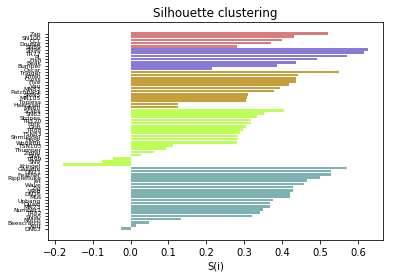

q es : 0.5277283335311086
labels_infomap.png


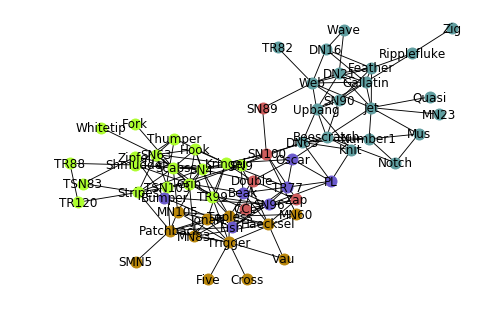

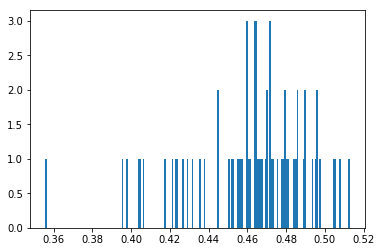

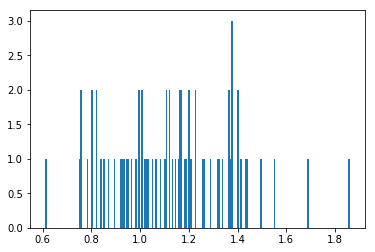

In [155]:
##### infomap
G = nx.read_gml("dolphins.gml")
labels_infomap = community(G, "infomap")
metodo="infomap"
Silmod(G, labels_infomap, fig_name = "G", metodo="infomap")
listq=[]
lists=[]
for rr in range(70):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=14)
    ##### infomap
    labels_infomap = community(R, "infomap")
    ss=Rsil(R, labels_infomap, fig_name = "G")
    mm=Rmod(R, labels_infomap, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)
plt.hist(listq, bins=200, range=None, density=None)
plt.show()
plt.hist(lists, bins=200, range=None, density=None)
plt.show()

In [ ]:
##### fast greedy
G = nx.read_gml("dolphins.gml")
labels_fast_greedy =nx.algorithms.community.greedy_modularity_communities(G, weight=None)
Silmodfg(G, labels_fast_greedy, fig_name = "G")
listq=[]
lists=[]
for rr in range(70):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=14)
    ##### infomap
    labels_fast_greedy = nx.algorithms.community.greedy_modularity_communities(G, weight=None)
    ss=Rsilfg(R, labels_fast_greedy, fig_name = "G")
    mm=Rmodfg(R, labels_fast_greedy, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)
plt.hist(listq, bins=200, range=None, density=None)
plt.show()
plt.hist(lists, bins=200, range=None, density=None)
plt.show()

In [ ]:
##### edges betweenness
G = nx.read_gml("dolphins.gml")
labels_edges_betweennes = community(G, "edge_betweenness")
Silmod(G, labels_edge_betweenness, fig_name = "G")
listq=[]
lists=[]
for rr in range(70):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=14)
    ##### infomap
    labels_edge_betweenness = community(G, "edge_betweenness")
    ss=Rsil(R, labels_edge_betweenness, fig_name = "G")
    mm=Rmod(R, labels_edge_betweenness, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)
plt.hist(listq, bins=200, range=None, density=None)
plt.show()
plt.hist(lists, bins=200, range=None, density=None)
plt.show()

In [ ]:
#### louvain
G = nx.read_gml("dolphins.gml")
labels_louvain = community(G, "louvain")
Silmod(G, labels_louvain, fig_name = "G")
listq=[]
lists=[]
for rr in range(70):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=14)
    ##### infomap
    labels_louvain = community(G, "louvain")
    ss=Rsil(R, labels_louvain, fig_name = "G")
    mm=Rmod(R, labels_louvain, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)
plt.hist(listq, bins=200, range=None, density=None)
plt.show()
plt.hist(lists, bins=200, range=None, density=None)
plt.show()

In [146]:
G= nx.read_gml('dolphins.gml')

###### Generar lista de edges de "dolphins.gml"
edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
filEdges = open("Dolphins_edge_list.txt", "r").readlines()	

edgeList = []
for a in range(len(filEdges)):
	edgeLine = filEdges[a].split()
	tupla = (edgeLine[0],edgeLine[1])
	edgeList.append(tupla)

###### Definir comunidades mediante el metodo fast_greedy
comus = nx.algorithms.community.greedy_modularity_communities(G, weight=None)



###### Definir all_nodes y community_lists
all_nodes = []
for x in range(len(comus)):
	lista = list(comus[x])
	all_nodes = all_nodes + lista
	
	print(lista)
	str1 = ','.join(lista)
	#outputFile.write("Community: " + str1 + "\n")
	# Defino node_community_lists
	globals()['node_list_community%s' % x] = lista
	#print(globals()['node_list_community%s' % x])
	#print(len(globals()['node_list_community%s' % x]))
	#print(x)
	print("\n")
	

###### Calculo de modularidad
q = nx.algorithms.community.modularity(G,comus)
print(comus)

['Stripes', 'Scabs', 'Fish', 'Fork', 'Shmuddel', 'TR88', 'Kringel', 'SN4', 'Bumper', 'Grin', 'Beak', 'TR77', 'TR120', 'TSN83', 'Hook', 'Whitetip', 'SN96', 'TR99', 'TSN103', 'SN63', 'Thumper', 'Zipfel', 'SN9']


['Beescratch', 'Web', 'SN90', 'Zig', 'MN23', 'Wave', 'Oscar', 'Knit', 'DN63', 'Number1', 'DN21', 'Upbang', 'Feather', 'Gallatin', 'Quasi', 'PL', 'Ripplefluke', 'TR82', 'Jet', 'Mus', 'Notch', 'DN16']


['Patchback', 'Five', 'MN60', 'Cross', 'SMN5', 'Double', 'MN105', 'Vau', 'Haecksel', 'Topless', 'Trigger', 'MN83', 'Zap', 'Jonah', 'CCL']


['SN89', 'SN100']


[frozenset({'Stripes', 'Scabs', 'Fish', 'Fork', 'Shmuddel', 'TR88', 'Kringel', 'SN4', 'Bumper', 'Grin', 'Beak', 'TR77', 'TR120', 'TSN83', 'Hook', 'Whitetip', 'SN96', 'TR99', 'TSN103', 'SN63', 'Thumper', 'Zipfel', 'SN9'}), frozenset({'Beescratch', 'Web', 'SN90', 'Zig', 'MN23', 'Wave', 'Oscar', 'Knit', 'DN63', 'Number1', 'DN21', 'Upbang', 'Feather', 'Gallatin', 'Quasi', 'PL', 'Ripplefluke', 'TR82', 'Jet', 'Mus', 'Notch', 'DN16